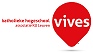<br>


**INTRODUCTION TO ARTIFICIAL INTELLIGENCE**<br>
Academiejaar 2024-2025<br>
Stefaan Haspeslagh<br>
Andy Louwyck<br>

---



---



# Maze: DFS en BFS

## Inleiding

Het doolhofprobleem is een veel gebruikt probleem om zoekalgoritmen op uit te testen. Een doolhof is een rooster met n x n vakken. Een vak kan een barrière bevatten, dit zijn vakjes waarop niet kan 'gewandeld' worden.
De uitdaging is om, gegeven een startpositie (links onder in het voorbeeld), een pad naar het doel te vinden (rechts boven in het voorbeeld).
Mogelijke richtingen waarin gewandeld kan worden (in die volgorde!) zijn: links, rechts, naar boven en naar onder. Diagonaal kan er niet gewandeld worden.

In deze notebook implementeren we het diepte-eerst- en breedte-eerst-algoritme, in het Engels Depth-First Search (DFS) en Breadth-First Search (BFS). We maken hierbij gebruik van de state-space en de production rules voor het doolhofprobleem die we in het vorige topic hebben uitgewerkt.

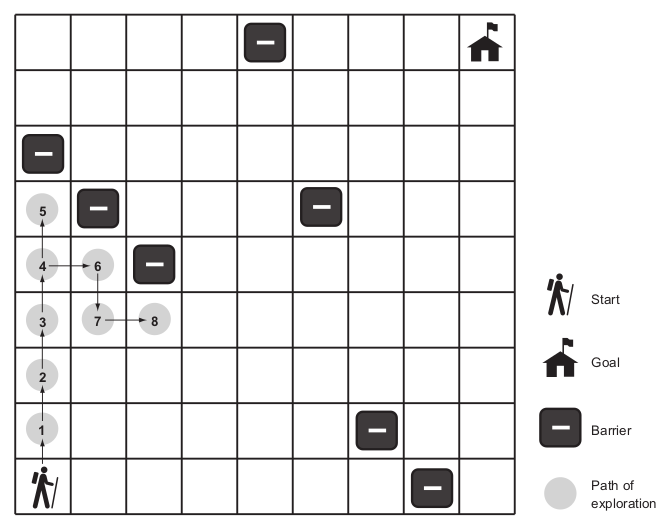

## State-Space Representation

We hebben een generiek OO-model geïmplementeerd waarin de volgende concepten een plaats kregen:

* **state**: een klasse waar de toestand van het zoekprobleem kan weergeven. Op een toestand moet je een move kunnen toepassen om naar een andere toestand te gaan.
* **goal**: van een bepaalde state moet je kunnen evalueren of die de goaltoestand is of niet.
* **move**: een move bepaalt hoe je van de ene naar de andere toestand kan overgaan.
* **production rule**: beschrijven welke 'acties' er kunnen uitgevoerd worden vanuit een state.
* **path**: is een opeenvolging van toestanden, die begint bij de initiële toestand, en hopelijk eindigt in de doeltoestand (goal).

De OO-structuur biedt een generiek kader waarin we verschillende zoekproblemen kunnen formuleren.

In [ ]:
# eerst importeren we de nodige Python packages, modules, klassen en functies
from abc import ABC, abstractmethod
from IPython.display import clear_output
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [ ]:
# abstracte superklasse State
class State(ABC):

    rules = []  # list met ProductionRule objecten
    
    def apply_production_rules(self):
        # Op een state wordt deze methode aangeroepen met de production rules om
        # de moves te berekenen die het probleem in een nieuwe toestand kunnen brengen.
        # Deze functie geeft dus een lijst van moves terug.
        return [rule.apply(self) for rule in self.rules]

    @abstractmethod
    def is_valid_move(self, move):
        # Het toepassen van een move op een state kan leiden tot een ongeldige toestand.
        # Deze functie controleert of een state al dan niet een geldige toestand van het probleem is.
        # Retourneert dus een boolean.
        pass
    
    @abstractmethod
    def apply_move(self, move):
        # Op een state kan een move toegepast worden om naar een volgende state over te gaan.
        # Deze functie geeft dus een nieuwe state terug.
        pass
    
    @abstractmethod
    def is_goal(self):
        # Controleert of een state de `goal state` is.
        # Retourneert dus een booleaanse waarde.
        pass
    
    @abstractmethod
    def __eq__(self, other):
        # Vergelijkt toestand self met een andere toestand other
        # nodig om te checken of er al dan niet loops zijn in een pad
        pass

In [ ]:
# superklasse Move
class Move:
    
    def __init__(self, state, rule, cost=1):
        # state is een State object
        # rule is een ProductionRule object
        self.state = state
        self.rule = rule
        self.cost = cost
    
    def is_valid(self):
        # Checkt of de Move self geldig is.
        # Retourneert True of False.
        return self.state.is_valid_move(self)
    
    def apply(self):
        # Past Move self toe op toestand state en geeft een nieuw State object terug
        return self.state.apply_move(self)

In [ ]:
# superklasse ProductionRule
class ProductionRule:
    
    def apply(self, state) -> Move:
        # methode die een Move object teruggeeft om ProductionRule self op self.state toe te kunnen passen
        return Move(state, self)

In [ ]:
# superklasse Path
class Path:
    
    def __init__(self, *states, cost=0):
        self.cost = cost # geaccumuleerd cost bijhouden
        self.states = states # een path is een opeenvolging van toestanden
    
    @property
    def length(self):
        # Geeft de lengte van het pad terug, dit is het aantal knopen op het pad,
        # dus het aantal toestanden dat bereikt worden op het pad
        return len(self.states)
    
    def has_loop(self):
        # Een pad bevat een 'loop' indien er twee toestanden op het pad gelijk zijn aan elkaar
        # aangezien de zoekalgoritmen telkens 'loops' verwijderen uit de queue
        # kan er enkel een loop ontstaan indien het pad uitgebreid wordt,
        # dus volstaat het enkel de laatst toegevoegde toestand op het pad te vergelijken met de voorgaande.
        return any([self.states[-1] == other for other in self.states[:-1]])
    
    def contains_state(self, state):
        # controleert of een pad langs een bepaalde toestand 'passeert'
        return state in self.states

    def reaches_goal(self):
        # Controleert of het pad naar de goaltoestand leidt.
        # Roept dus de methode is_goal() op de laatste toestand op het pad op.
        return self.states[-1].is_goal()

    def calculate_children(self):
        # Activeert de "production rules" op de laatste state, om nieuwe afstammelingen (descendants)
        # te genereren. De paden naar die nieuwe descendants zijn de kinderen van het huidige pad (self).
        # Let op! Die paden kunnen loops bevatten!
        moves = self.states[-1].apply_production_rules()
        return [self.__extend(move.apply(), move.cost) for move in moves if move.is_valid()]
    
    def last_state(self):
        return self.states[-1]
    
    def __extend(self, state, cost):
        # Voegt een toestand toe aan het huidige pad.
        # Geeft dus een nieuw pad terug, dat leidt tot de opgegeven toestand.
        return Path(*self.states, state, cost=self.cost+cost)
    
    def __repr__(self):
        # Een pad is een opeenvolging van states.
        # De generieke string-voorstelling van een pad is dus de string-voorstelling van die states.
        states = ", ".join([str(state) for state in self.states])
        return f"[{states}]"

Daarna hebben we overerving toegepast om ons specifieke doolhofprobleem te implementeren. Onderstaande klassen implementeren deze concepten.

In [ ]:
# klasse Position
class Position:
  
    def __init__(self, irow, icol):
        # Een positie definiëren we adhv rij index irow en kolom index icol van het vakje
        self.irow = irow
        self.icol = icol

    def __eq__(self, other):
        # Twee posities zijn hetzelfde als hun rij en kolom indices gelijk zijn
        return self.irow == other.irow and self.icol == other.icol
    
    def __repr__(self):
        # String voorstelling van de positie: (irow, icol)
        return "({}, {})".format(self.irow, self.icol)

In [ ]:
# klasse Maze met de doolhofconfiguratie
class Maze:
   
    symbols = ('*', '.', '#', 'o')  # start = *, free = ., wall = #, goal = o 
    
    def __init__(self, grid):
        # grid is een integer array:
        # start = 0, free = 1, wall = 2, goal = 3
        self.grid = np.array(grid)
        self.size = self.grid.shape[0]  # aantal rijen = aantal kolommen van het doolhof rooster

    def get_start_position(self):
        # Retourneert startpositie (= Position object)
        irow, icol = np.where(self.grid == 0)
        return Position(irow[0], icol[0])

    def get_goal_position(self):
        # Retourneert eindpositie (= Position object)
        irow, icol = np.where(self.grid == 3)
        return Position(irow[0], icol[0])
    
    def is_valid_position(self, position):
        # Checkt of een positie geldig is: moet binnen het grid liggen en mag geen barrière zijn
        return (0 <= position.irow < self.size and
                0 <= position.icol < self.size and 
                self.grid[position.irow, position.icol] != 2)
    
    def plot(self):
        # Plot het doolhof
        cmap = colors.ListedColormap(['forestgreen', 'lightyellow', 'purple', 'red'])  # colormap
        bounds = np.linspace(-0.5, 3.5, 5)
        norm = colors.BoundaryNorm(bounds, cmap.N)
        # plot grid
        plt.matshow(self.grid, cmap=cmap, norm=norm)
        # axes
        xmax = self.size - 0.5
        ymax = self.size - 0.5
        ax = plt.gca()
        ax.set_aspect("equal")
        ax.set_xticks(np.linspace(-0.5, xmax, self.size + 1))
        ax.set_xticklabels([])
        ax.set_yticks(np.linspace(-0.5, ymax, self.size + 1))
        ax.set_yticklabels([])
        ax.tick_params(axis=u'both', which=u'both', length=0)
        # plot grid and set axis limits
        plt.grid()
        plt.xlim([-0.5, xmax])
        plt.ylim([ymax, -0.5])
        
    def __repr__(self):
        # String representatie van het doolhof
        return "\n".join([''.join([self.symbols[item] for item in row]) for row in self.grid])

    @staticmethod
    def create(maze):
        # Creëert grid adhv list van list met strings "maze"
        # Retourneert een Maze object
        return Maze(grid=[[Maze.symbols.index(symbol) for symbol in row] for row in maze])

Nu kunnen we de subklassen `MazeProductionRule`, `MazeMove` en `MazeState` definiëren. Om ons het leven wat makkelijker te maken hebben ook de `MazeProductionRule` subklassen `Left`, `Right`, `Up` en `Down` gecreëerd. Merk op dat we in die laatste klasse onze productieregels "left, right, up, down" in attribuut `rules` stoppen en dat we een methode `set_production_rules` hebben toegevoegd waarmee we die `rules` kunnen wijzigen.

In [ ]:
# klasse MazeProductionRule die erft van klasse ProductionRule
class MazeProductionRule(ProductionRule):

    def __init__(self, drow=0, dcol=0):
        # Een production rule in dit geval is één vakje naar links, rechts, boven of onder opschuiven
        # De nieuwe positie heeft coördinaat (irow+drow, icol+dcol)
        super().__init__()
        self.drow = drow
        self.dcol = dcol

    def __repr__(self):
        # We stellen de production rule voor als 'left', 'right', 'up' of 'down'.
        if self.dcol == -1:
            return 'left'
        if self.dcol == 1:
            return 'right'
        if self.drow == -1:
            return 'up'
        if self.drow == 1:
            return 'down'

# subklassen Left, Right, Up, Down
class Left(MazeProductionRule):
    def __init__(self):
        super().__init__(0, -1)

class Right(MazeProductionRule):
    def __init__(self):
        super().__init__(0, 1)

class Up(MazeProductionRule):
    def __init__(self):
        super().__init__(-1, 0)

class Down(MazeProductionRule):
    def __init__(self):
        super().__init__(1, 0)

In [ ]:
# klasse MazeMove die erft van klasse Move
class MazeMove(Move):

    def __init__(self, state, rule):
        super().__init__(state, rule)
    
    def __repr__(self):
        # Een Move kunnen we op dezelfde manier voorstellen als de overeenkomstige ProductionRule
        return str(self.rule)

In [ ]:
# klasse MazeState die erft van State
class MazeState(State):

    rules = [Left(), Right(), Up(), Down()]  # alle mogelijke acties, in die volgorde!
    
    def __init__(self, maze, position):
        # Een toestand wordt gekenmerkt door positie in het doolhof
        # vandaar attributen maze en position 
        super().__init__()
        self.maze = maze
        self.position = position

    def is_valid_move(self, move):
        # Checkt of move leidt tot een geldige positie in self.maze
        new_position = Position(self.position.irow + move.rule.drow,
                                self.position.icol + move.rule.dcol)
        return self.maze.is_valid_position(new_position)
    
    def apply_move(self, move):
        # Past move toe op State self om een nieuwe State te krijgen
        new_position = Position(self.position.irow + move.rule.drow,
                                self.position.icol + move.rule.dcol)
        return MazeState(self.maze, new_position)  # nieuwe toestand
    
    def is_goal(self):
        # Checkt of State self de eindtoestand is
        return self.maze.get_goal_position() == self.position
    
    def get_position(self):
        return self.position
    
    def set_production_rules(self, *rules):
        # rules is input lijst met production rules objecten
        self.rules = rules # [r for r in rules]
    
    def __eq__(self, other):
        # State self is gelijk aan State other als hun posities gelijk zijn
        return self.position == other.position
    
    def __repr__(self):
        # String voorstelling van de State self is de positie
        return str(self.position)

Ten slotte laden we ook de `MazePathPlotter` in:

In [ ]:
# klasse MazePathPlotter
class MazePathPlotter:
    
    def __init__(self, path):
        self.path = path  # Path object met states en dus posities
    
    def plot(self):
        state = self.path.states[-1]
        state.maze.plot()
        x = np.arange(0, state.maze.grid.size)
        plt.plot(x[state.position.icol], x[state.position.irow], 'bo')
        positions = [state.position for state in self.path.states[:-1]]
        irow = np.array([position.irow for position in positions])
        icol = np.array([position.icol for position in positions])
        if len(positions) > 0:
            plt.plot(x[icol], x[irow], 'ko')
            
    def plot_dynamic(self, wait=0.5):
        state = self.path.states[-1]
        x = np.arange(0, state.maze.grid.size)
        icol, irow = [], []
        for position in [state.position for state in self.path.states]:
            state.maze.plot()
            irow.append(position.irow)
            icol.append(position.icol)
            plt.plot(x[icol], x[irow], 'ko')
            plt.show()
            sleep(wait)
            clear_output()
        self.plot()  

We zijn klaar nu om het doolhofprobleem op te lossen door gebruik te maken van zoekalgoritmen. We starten met de bekende blinde zoekalgoritmen diepte-eerst en breedte-eerst. 

Maar laten we eerst ons doolhofvoorbeeldje uit de vorige notebook implementeren zodat we een testcase hebben.

### Voorbeeld

We creëren het volgende doolhof aan de hand van de statische methode `Maze.create`:

```python
['o....',
 '.###.',
 '.#*#.',
 '.#...',
 '.....']
```
We kennen het geretourneerde `Maze` object toe aan variabele `maze`. We maken een plot om te zien of het doolhof correct is gedefinieerd.

In [ ]:
maze = Maze.create(['o....',
                    '.###.',
                    '.#*#.',
                    '.#...',
                    '.....'])

maze.plot()

## DFS en BFS

Met een zoekalgoritme willen we op zoek gaan naar een pad in de zoekboom waardoor je de goal kan bereiken. Meestal zal je de volledige zoekboom niet expliciet berekenen. Voor diepte-eerst en breedte-eerst doen we dit inderdaad ook niet. 

We moeten wel een pad kunnen voorstellen van startpositie naar doel. Een node in de zoekboom komt immers overeen met een pad. Maar omdat onze toestand het pad al bevat, komt elke node in de zoekboom ook overeen met een toestand. In de pseudocode van DFS en BFS kunnen we 'path' daarom eenvoudigweg vervangen door 'state', en de 'root' van onze zoekboom komt dus overeen met de 'initial state'.

We vertalen de pseudocode van beide algoritmen naar Python code en passen die toe op ons `maze` probleem.

### Diepte-eerst

De pseudocode van DFS uit de cursus:

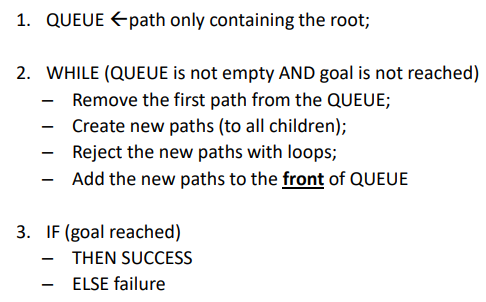

Die pseudocode kunnen we nu makkelijk vertalen naar Python code, als we 'path' vervangen door de overeenkomstige `MazeState` objecten, zoals we hierboven hebben uitgelegd:

In [ ]:
def dfs(initial_path):
# initial_path is Path object containing the initial state


We zien dat DFS het LIFO principe toepast: **last in first out!**

We maken nu een `initial_state` en een `initial_path` aan zoals gezien in het vorige topic.

We passen het algoritme toe op het initiële pad:

We kunnen het doorlopen van het pad nu ook 'live' gaan plotten:

### Breedte-eerst

De pseudocode van BFS uit de cursus:

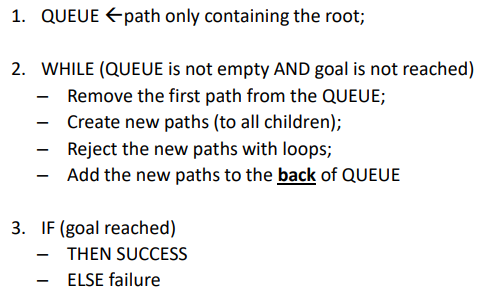

Het algoritme is hetzelfde als dat van DFS, alleen moeten we nieuwe paden *achteraan* de queue toevoegen i.p.v. vooraan, want BFS past het FIFO principe toe: **first in first out!**

In [ ]:
def bfs(initial_path):
# initial_path is Path object containing the initial state


We hebben dus de code van DFS kunnen kopiëren, en enkel het volgende lijntje code moesten we aanpassen:

```python
# add the new paths to the BACK of the queue
queue = queue + new_states
```

We krijgen echter een totaal andere oplossing, want in tegenstelling tot DFS, **vindt BFS het kortste pad!** 

In [ ]:
solution = bfs(initial_path)
path_plotter = MazePathPlotter(solution)
path_plotter.plot_dynamic()

## Opdrachten

### Opdracht 1

Voer DFS en BFS opnieuw uit maar print nu na elke iteratie de laatste positie van de paden in de queue uit. De laatste positie van een pad is het vakje waar men staat in die toestand. 

Welk algoritme is het snelst? Welk algoritme heeft het minst geheugen nodig?

DFS:

In [ ]:
solution = dfs(initial_path)

BFS:

In [ ]:
solution = bfs(initial_path)

Het is duidelijk dat in dit geval DFS minder rekentijd nodig heeft om een oplossing te vinden en ook minder geheugen. DFS vindt wel niet het kortste pad...

### Opdracht 2

Pas DFS en BFS toe op de doolhof uit de figuur aan het begin van de notebook.

Wat is nu het snelste algoritme? Welk heeft het minste geheugen nodig? En welk vindt het kortste pad?

In [ ]:
maze2 = Maze.create(['....#...o',
                     '.........',
                     '#........',
                     '.#...#...',
                     '..#......',
                     '.........',
                     '.........',
                     '......#..',
                     '*......#.'])
maze2.plot()

Maak het initiële pad aan:

We gaan de rekentijd chronometreren met functie `time` uit de gelijknamige module:

In [ ]:
from time import time

Het uitprinten van de queue wordt in dit geval lastig. Daarom gaan we de lengte van de queue bijhouden in een list. De maximale lengte zal ons een idee geven van het geheugengebruik.

DFS:

In [ ]:
solution = dfs(initial_path2)

BFS:

In [ ]:
solution = bfs(initial_path2)

Ook hier is DFS (veel) sneller en gebruikt het (veel) minder geheugen, maar het vindt zeker en vast niet het kortste pad, terwijl BFS dat uiteraard wel doet. We hebben duidelijk nood aan "intelligentere" algoritmes...

### Opdracht 3

Al dat gekopieer is natuurlijk niet volgens de regels van de kunst van het programmeren. Kan je de code voor DFS en BFS in één functie stoppen?

Test je functie uit op het `maze` voorbeeldje.

Bemerk dat we een initieel pad opgeven, omdat we een generieke functie willen die onafhankelijk is van het doolhofprobleem!

### Opdracht 4

Maak onderstaand doolhof aan en pas DFS en BFS toe om een oplossing te vinden:

```python
['......o',
 '.#####.',
 '.......',
 '.#####.',
 '.......',
 '.#####.',
 '*......']
```

Vergelijk opnieuw snelheid en geheugen, en check of het kortste pad wordt gevonden.

In [ ]:
# dfs

In [ ]:
# bfs

### Opdracht 5

Neem hetzelfde doolhof als in opdracht 4, en pas opnieuw DFS en BFS toe, maar wijzig nu de volgorde van de production rules naar "onder, boven, rechts, links" in plaats van "links, rechts, boven, onder". Krijg je nog steeds dezelfde oplossing? Heeft het wijzigen van die volgorde invloed op rekentijd en geheugengebruik?

Tip: Klasse `MazeState` bevat een methode `set_production_rules` waarmee je de volgorde makkelijk kan wijzigen. In dit geval:

```
maze_state_object.set_production_rules(Down(), Up(), Right(), Left())
```

In [ ]:
# initial state en path definiëren

# volgorde van de production rules wijzigen


In [ ]:
# dfs


In [ ]:
# bfs


Het is duidelijk dat het wijzigen van de volgorde waarin de productieregels worden toegepast tot andere oplossingen leidt.

Kan je ook de oplossing van BFS verklaren? Waarom neemt die niet de onderste rij?

### Opdracht 6

Verzin nu zelf enkele doolhofproblemen en pas er DFS en BFS op toe. Speel ook met de volgorde van de production rules. Bestudeer de bekomen oplossingen door de inhoud van de queue na elke iteratie te analyseren. Op het examen moet je in staat zijn om zelf de oplossing van die algoritmes te geven!